In [1]:
from plotly_calplot import calplot

from common.explore import display_sql

In [2]:
display_sql(f'''
CREATE OR REPLACE VIEW test_changelog AS
WITH
   online_job_with_previous AS (
    SELECT job_id,
           online_at,
           online_at - INTERVAL 1 DAY AS previous_day
      FROM fact_online_job
     --WHERE online_at >= current_date - INTERVAL 30 DAY
), min_online_at AS (
    SELECT MIN(online_at)
      FROM online_job_with_previous
), max_online_at AS (
    SELECT MAX(online_at)
      FROM online_job_with_previous
), joined_online_job_with_previous AS (
    SELECT DISTINCT
           c.job_id,
           c.online_at,
           p.online_at as previous_online_at,
           p.job_id previous_job_id
      FROM online_job_with_previous c
      FULL OUTER JOIN online_job_with_previous p
        ON (c.job_id = p.job_id AND
            c.previous_day = p.online_at)
)
SELECT previous_job_id AS job_id,
       (previous_online_at + INTERVAL 1 DAY) AS online_at,
       'deleted' AS change
  FROM joined_online_job_with_previous
 WHERE job_id IS NULL
   AND previous_online_at NOT IN (SELECT * FROM max_online_at)
UNION ALL
SELECT job_id AS job_id,
       online_at AS online_at,
       'added' AS change
  FROM joined_online_job_with_previous
 WHERE previous_job_id IS NULL
   AND online_at NOT IN (SELECT * FROM min_online_at)
''', read_only=False)

,Count


In [3]:
df = display_sql(f'''
SELECT online_at,
       change,
       COUNT(*)
  FROM test_changelog
 GROUP BY 1, 2
 ORDER BY 1, 2
''')
df

,online_at,change,count_star()
0,2021-10-10,added,474
1,2021-10-10,deleted,2977
2,2021-10-11,added,3376
3,2021-10-11,deleted,2946
4,2021-10-12,added,3805
...,...,...,...
738,2022-10-18,deleted,3168
739,2022-10-19,added,3842
740,2022-10-19,deleted,1729
741,2022-10-20,added,5138


In [4]:
df = display_sql(f'''
SELECT online_at,
       COUNT(*) AS added
  FROM test_changelog
 WHERE change = 'added'
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,added
0,2021-10-10,474
1,2021-10-11,3376
2,2021-10-12,3805
3,2021-10-13,3681
4,2021-10-14,3923
...,...,...
370,2022-10-16,580
371,2022-10-17,3415
372,2022-10-18,4144
373,2022-10-19,3842


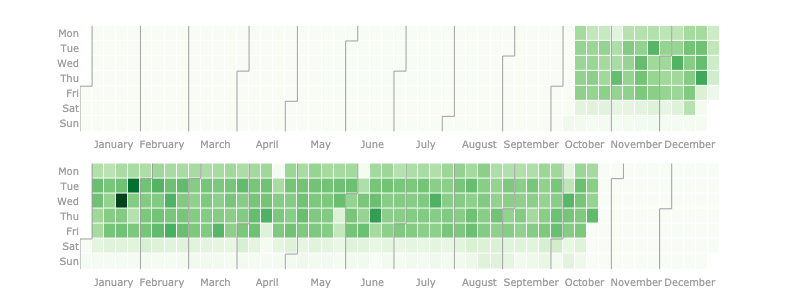

In [5]:
fig = calplot(
    df,
    x='online_at',
    y='added',
    colorscale='Greens'
)
fig.show('png')

In [6]:
df = display_sql(f'''
SELECT online_at,
       COUNT(*) AS deleted
  FROM test_changelog
 WHERE change = 'deleted'
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,deleted
0,2021-10-10,2977
1,2021-10-11,2946
2,2021-10-12,1419
3,2021-10-13,1491
4,2021-10-14,3344
...,...,...
363,2022-10-16,3889
364,2022-10-17,3185
365,2022-10-18,3168
366,2022-10-19,1729


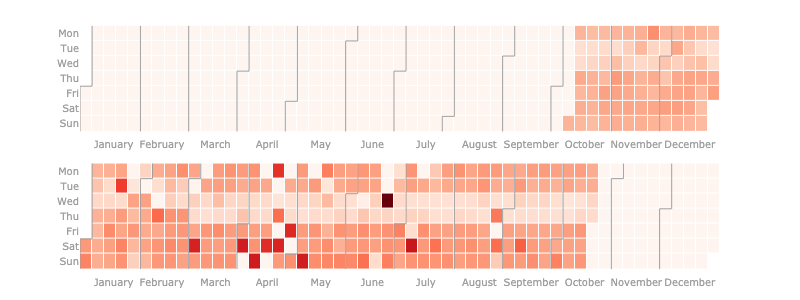

In [7]:
fig = calplot(
    df,
    x='online_at',
    y='deleted',
    colorscale='Reds'
)
fig.show('png')

In [8]:
display_sql(f'''
DROP VIEW test_changelog
''', read_only=False)

,Success
